## Imports

In [1]:
import glob
import os
import random
import torch
import torchvision

import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from typing import Tuple, Any, Callable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = (
    "True"  # A fix for some strange matplotlib error
)

In [3]:
MODELS_DIR = "models"
DATASET_DIR = "dataset"

In [4]:
IMAGE_SIZE = 224

## Set seed

In [5]:
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [68]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.Tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos

def classify_left_value(left):
    if left >= 0.005:
        return 1
    elif left <= -0.005:
        return -1
    else:
        return 0

df, photos = load_data(DATASET_DIR)

df['left_class'] = df['left'].apply(classify_left_value)

df['left_class'].value_counts()

left_class
 0    4202
-1    1708
 1    1674
Name: count, dtype: int64

In [69]:
df.describe()

,filename,forward,left,left_class
count,7584.000000,7584.000000,7584.000000,7584.000000
mean,393.938423,0.869385,-0.002110,-0.004483
std,235.443685,0.212493,0.647074,0.667815
min,5.000000,-0.992188,-1.000000,-1.000000
25%,199.000000,0.789062,0.000000,0.000000
50%,371.000000,0.968750,0.000000,0.000000
75%,564.000000,1.000000,0.000000,0.000000
max,999.000000,1.000000,0.992188,1.000000


In [70]:
df

,filename,forward,left,folder_name,left_class
photo_id,,,,,
0,24,0.039062,0.000000,dataset\1652875851.3497071,0
1,25,0.210938,0.000000,dataset\1652875851.3497071,0
2,26,0.390625,0.000000,dataset\1652875851.3497071,0
3,27,0.421875,0.000000,dataset\1652875851.3497071,0
4,28,0.421875,0.000000,dataset\1652875851.3497071,0
...,...,...,...,...,...
7579,113,0.398438,0.992188,dataset\1653043549.5187616,1
7580,114,0.367188,0.992188,dataset\1653043549.5187616,1
7581,115,0.367188,0.992188,dataset\1653043549.5187616,1


## Create flip of every image that suggests rotation.

In [9]:
# import torchvision.transforms.functional as F
# from PIL import Image
# import torchvision.transforms as transforms

# def horizontal_flip(df: pd.DataFrame, photos: torch.Tensor):
#     output_csv_path = f'{DATASET_DIR}\\flipped.csv'
#     flipped_data = []
#     for idx, row in df.iterrows():
#         left_class = row['left_class']
#         if left_class in [1, -1]:
#             img = photos[idx]
#             flipped_img = F.hflip(img)

#             img_filename = f'{DATASET_DIR}\\flipped\\{idx}.jpg'
#             os.makedirs(os.path.dirname(img_filename), exist_ok=True)  # Ensure the directory exists
#             flipped_img_pil = transforms.ToPILImage()(flipped_img)
#             flipped_img_pil.save(img_filename)
            
#             flipped_left_value = -row['left']
            
#             flipped_data.append({
#                 'filename': f'{idx}',
#                 'forward': row['forward'],
#                 'left': flipped_left_value
#             })
    
#     # Write the flipped data to CSV
#     flipped_df = pd.DataFrame(flipped_data)
#     flipped_df.to_csv(output_csv_path, index=False)

# horizontal_flip(df, photos, )

## Dataset

In [10]:
class JetbotDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: torch.Tensor,
        transforms: list | None = None,
        image_transforms: list | None = None,
        normalize_images: bool = True
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        if transforms is None:
            transforms = []
        self.df = df
        self.images = images
        self.transforms = transforms
        self.image_transforms = image_transforms
        self.normalize_images = normalize_images
        if image_transforms is None:
            self.image_transforms = []

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left], dtype=torch.float32)
        img = self.images[index]
        for transform in self.image_transforms:
            img = transform(img)
        for transform in self.transforms:
            img, target = transform(img, target)
        img = img.float()
        if self.normalize_images:
            img = img / 255.0
        return img, target

In [11]:
def display_image(img: torch.Tensor, target: torch.Tensor = None):
    temp_img = img.numpy().transpose((1, 2, 0))
    if img.max() > 1.0:
        temp_img = temp_img.astype(np.uint8)
    plt.imshow(temp_img)
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [65]:
import torchvision.transforms.functional


class RandomJetbotGamma(torch.nn.Module):
    def __init__(self, p: float = 0.3, gamma_range: tuple[float, float] = (0.5,2.5)):
        super().__init__()
        self.p = p
        self.gamma_range = gamma_range

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            gamma = np.random.uniform(self.gamma_range[0], self.gamma_range[1])
            img = torchvision.transforms.functional.adjust_gamma(img, gamma)
        return img, target
    

class RandomJetbotContrast(torch.nn.Module):
    def __init__(self, p: float = 0.3, contrast_range: tuple[float, float] = (0.5, 2)):
        super().__init__()
        self.p = p
        self.contrast_range = contrast_range

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            contrast_factor = np.random.uniform(self.contrast_range[0], self.contrast_range[1])
            img = torchvision.transforms.functional.adjust_contrast(img, contrast_factor)
        return img, target


class RandomJetbotSaturation(torch.nn.Module):
    def __init__(self, p: float = 0.3, saturation_rage: tuple[float, float] = (0.1, 3)):
        super().__init__()
        self.p = p
        self.saturation_rage = saturation_rage

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            saturation_factor = np.random.uniform(self.saturation_rage[0], self.saturation_rage[1])
            img = torchvision.transforms.functional.adjust_saturation(img, saturation_factor)
        return img, target


class RandomJetbotBrightness(torch.nn.Module):
    def __init__(self, p: float = 0.3, brightness_range: tuple[float, float] = (0.7, 1.5)):
        super().__init__()
        self.p = p
        self.brightness_range = brightness_range

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            brightness_factor = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
            img = torchvision.transforms.functional.adjust_brightness(img, brightness_factor)
        return img, target


class RandomCutout(torch.nn.Module):
    def __init__(self, num_holes: int = 1, max_h_size: int = 16, max_w_size: int = 16, p: float = 0.3) -> None:
        super().__init__()
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.p = p

    def forward(self, img: torch.Tensor, target: torch.Tensor) -> Any:
        if np.random.random() < self.p:
            h, w = img.shape[1], img.shape[2]
            
            for _ in range(self.num_holes):
                y = random.randint(0, h - 1)
                x = random.randint(0, w - 1)
                y1 = np.clip(y - self.max_h_size // 2, 0, h)
                y2 = np.clip(y + self.max_h_size // 2, 0, h)
                x1 = np.clip(x - self.max_w_size // 2, 0, w)
                x2 = np.clip(x + self.max_w_size // 2, 0, w)
                img[:, y1:y2, x1:x2] = 0
        return img, target
    

class CropJetbotTop(nn.Module): # Keeps only the road, as the top part of the image is mostly irrelevant
    def __init__(self, percent_crop: float = 0.3):
        super().__init__()
        assert percent_crop <= 1.0
        self.top = int(IMAGE_SIZE * percent_crop)
        self.height = int(IMAGE_SIZE * (1 - percent_crop))

    def forward(self, img: torch.Tensor):
        return torchvision.transforms.functional.resized_crop(
            img, self.top, 0, self.height, IMAGE_SIZE, (IMAGE_SIZE, IMAGE_SIZE)
        )


train_transforms = [
    RandomJetbotGamma(gamma_range=(0.6, 1.4)),
    RandomJetbotContrast(),
    RandomJetbotSaturation(),
    RandomJetbotBrightness(),
    RandomCutout()
]
test_transforms = []  
test_transforms = []
image_transforms = [] #[CropJetbotTop()]

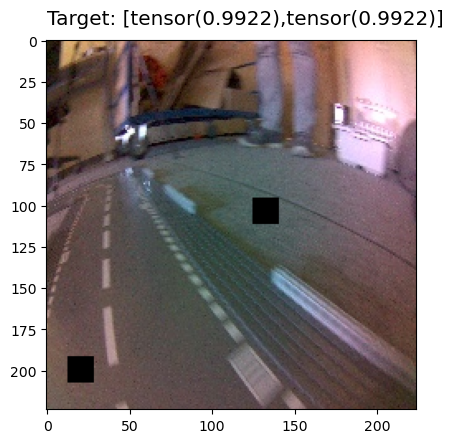

In [66]:
dataset = JetbotDataset(df, photos, train_transforms)
img, target = dataset[400]
display_image(img, target)

## Train-test-validation split

In [71]:
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

train_indices, val_test_indices = train_test_split(df.index, test_size=val_size+test_size, stratify=df['left_class'])
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_size/(val_size+test_size), stratify=df.loc[val_test_indices, 'left_class'])

print(df.loc[train_indices]['left_class'].value_counts())
print(df.loc[val_indices]['left_class'].value_counts())
print(df.loc[test_indices]['left_class'].value_counts())

df = df.drop(columns=['left_class'])

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[train_indices],
        photos[train_indices],
        transforms=train_transforms,
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[val_indices],
        photos[val_indices],
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[test_indices],
        photos[test_indices],
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

left_class
 0    2941
-1    1195
 1    1172
Name: count, dtype: int64
left_class
 0    631
-1    256
 1    251
Name: count, dtype: int64
left_class
 0    630
-1    257
 1    251
Name: count, dtype: int64


## Training / Evaluation functions.

In [72]:
from pathlib import Path


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        save_dir: str | Path,
        save_name: str,
        optimizer: torch.optim.Optimizer,
        loss_func: Callable[..., torch.Tensor],
        early_stopping: int | None = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.save_dir = Path(save_dir)
        self.save_name = save_name
        self.history = {"train_loss": [], "valid_loss": []}

        self.min_valid_loss = np.inf
        self.early_stopping = early_stopping

    def train_model(
        self,
        epochs: int,
        trainloader: DataLoader,
        validloader: DataLoader,
        *,
        force_cuda: bool = False,
    ):
        if force_cuda and torch.cuda.is_available():
            self.model.cuda()

        if self.early_stopping is not None:
            epochs_no_improvement = 0

        for e in range(epochs):
            train_loss = 0.0
            self.model.train()  # Optional when not using Model Specific layer
            for data, labels in tqdm(trainloader):
                if force_cuda and torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                self.optimizer.zero_grad()
                target = self.model(data)
                loss = self.loss_func(target, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            valid_loss = 0.0
            self.model.eval()  # Optional when not using Model Specific layer
            for data, labels in tqdm(validloader):
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                target = self.model(data)
                loss = self.loss_func(target, labels)
                valid_loss += loss.item()

            avg_train_loss = train_loss / len(trainloader)
            avg_valid_loss = valid_loss / len(validloader)

            self.history["train_loss"].append(avg_train_loss)
            self.history["valid_loss"].append(avg_valid_loss)

            print(
                f"Epoch {e+1} \t\t Training Loss: {avg_train_loss} \t\t Validation Loss: {avg_valid_loss}"
            )

            if self.min_valid_loss > avg_valid_loss:
                print(
                    f"Validation Loss Decreased({self.min_valid_loss:.6f}--->{avg_valid_loss:.6f}) \t Saving The Model"
                )
                self.min_valid_loss = avg_valid_loss
                # Saving State Dict
                torch.save(
                    self.model.state_dict(),
                    self.save_dir / f"{self.save_name}_best.pth",
                )

                if self.early_stopping is not None:
                    epochs_no_improvement = 0
            else:
                if self.early_stopping is not None:
                    epochs_no_improvement += 1

                if (
                    self.early_stopping is not None
                    and epochs_no_improvement >= self.early_stopping
                ):
                    print(f"Early stopping after {self.early_stopping} epochs!")
                    break

        torch.save(
            self.model.state_dict(), self.save_dir / f"{self.save_name}_last.pth"
        )

    def plot_losses(self, ax: plt.Axes | None = None):
        if ax is None:
            fig, ax = plt.subplots(1, 1)
            ax: plt.Axes
        ax.plot(self.history["train_loss"], label="train_loss")
        ax.plot(self.history["valid_loss"], label="valid_loss")
        ax.title("Training History")
        ax.legend()

In [73]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_func: callable,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = loss_func(outputs, labels)
            
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

## Custom loss function

In [17]:
class CustomLoss(nn.Module):
    def __init__(self, device):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor([1, 5]).to(device)

    def forward(self, predictions, targets):
        loss = torch.mean(self.weights * (predictions - targets) ** 2).to(device)
        return loss
    

device = torch.device('cuda')

## Exporting to ONNX

In [18]:
import onnxruntime as ort

input_t = torch.randint(0, 256, (1, 3, 224, 224), dtype=torch.float32)

def export_to_onnx_from_file(model_cls: type[nn.Module], pth_file: str, onnx_file: str):
    model = model_cls()
    model.load_state_dict(torch.load(pth_file))
    onnx_program = torch.onnx.export(model, input_t, onnx_file, opset_version=11)

def run_onnx_on_dummy_input(onnx_file: str):
    ort_sess = ort.InferenceSession(onnx_file)
    outputs = ort_sess.run(None, {'input.1': input_t.numpy()})
    return outputs

def export_to_onnx(model: nn.Module, pth_file: str, onnx_file: str, input_size: tuple):
    model.load_state_dict(torch.load(pth_file))
    model.eval()
    input_t = torch.randn(input_size).to(next(model.parameters()).device)

    torch.onnx.export(
        model, 
        input_t, 
        onnx_file, 
        opset_version=11, 
        input_names=['input'], 
        output_names=['output']
    )

## Model from the paper

In [74]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        
        # Normalization layer (input normalization)
        self.normalize = nn.BatchNorm2d(3)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)

        # Calculate the number of output neurons after the last convolutional layer
        self.flattened_size = self._get_flattened_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 2)

    def _get_flattened_size(self):
        # Helper function to calculate the number of neurons after convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            return x.numel()

    def forward(self, x):
        x = self.normalize(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

# Testing the model with a sample input
model = CustomNetwork()
model = model.to(device)
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.MSELoss()

CustomNetwork(
  (normalize): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28224, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)
Number of trainable parameters: 2959436


In [75]:
trainer = Trainer(
    model=model,
    save_dir=MODELS_DIR,
    save_name="ModelPaper",
    optimizer=optimizer,
    loss_func=loss
)

In [76]:
trainer.train_model(
    epochs=15,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    force_cuda=True
)

100%|██████████| 18/18 [00:01<00:00, 14.43it/s]


Epoch 1 		 Training Loss: 0.42354592196194524 		 Validation Loss: 0.27135996023813885
Validation Loss Decreased(inf--->0.271360) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


Epoch 2 		 Training Loss: 0.25031149943909015 		 Validation Loss: 0.22461761948135164
Validation Loss Decreased(0.271360--->0.224618) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.82it/s]


Epoch 3 		 Training Loss: 0.2341128302266799 		 Validation Loss: 0.22169056038061777
Validation Loss Decreased(0.224618--->0.221691) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 14.71it/s]


Epoch 4 		 Training Loss: 0.23338393472045302 		 Validation Loss: 0.2215383607480261
Validation Loss Decreased(0.221691--->0.221538) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 11.95it/s]


Epoch 5 		 Training Loss: 0.23344596699777856 		 Validation Loss: 0.22149634692404005
Validation Loss Decreased(0.221538--->0.221496) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 15.93it/s]


Epoch 6 		 Training Loss: 0.23317308041704707 		 Validation Loss: 0.22142543312576082
Validation Loss Decreased(0.221496--->0.221425) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.49it/s]


Epoch 7 		 Training Loss: 0.233202694051237 		 Validation Loss: 0.2213667689098252
Validation Loss Decreased(0.221425--->0.221367) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.25it/s]


Epoch 8 		 Training Loss: 0.23300188959362994 		 Validation Loss: 0.2212550789117813
Validation Loss Decreased(0.221367--->0.221255) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 15.20it/s]


Epoch 9 		 Training Loss: 0.23284253567816263 		 Validation Loss: 0.22109323905573952
Validation Loss Decreased(0.221255--->0.221093) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 13.87it/s]


Epoch 10 		 Training Loss: 0.23250721197530447 		 Validation Loss: 0.22086296478907266
Validation Loss Decreased(0.221093--->0.220863) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 14.35it/s]


Epoch 11 		 Training Loss: 0.23230831378913788 		 Validation Loss: 0.22065990252627266
Validation Loss Decreased(0.220863--->0.220660) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.14it/s]


Epoch 12 		 Training Loss: 0.23189890887363848 		 Validation Loss: 0.22037626140647465
Validation Loss Decreased(0.220660--->0.220376) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00,  9.78it/s]


Epoch 13 		 Training Loss: 0.23126967825803413 		 Validation Loss: 0.21996909462743336
Validation Loss Decreased(0.220376--->0.219969) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 11.56it/s]


Epoch 14 		 Training Loss: 0.23100795121078033 		 Validation Loss: 0.2195467087957594
Validation Loss Decreased(0.219969--->0.219547) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 11.24it/s]


Epoch 15 		 Training Loss: 0.23036506789994526 		 Validation Loss: 0.21898374789290959
Validation Loss Decreased(0.219547--->0.218984) 	 Saving The Model


In [27]:
model.load_state_dict(torch.load(f"{MODELS_DIR}/ModelPaperaugmentations_mse.pth"))

avg_loss = evaluate_model(model, test_dataloader, CustomLoss(device))
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 1.4599
